### Metrics to report

In [ ]:
import pandas as pd
import requests
import numpy as np

In [ ]:
PROMETHEUS_PORT=31702
WORKER_NODE_IP='10.44.112.6'

# command to convert time from date: date -d "" --utc +%Y-%m-%dT%H:%M:%SZ
TIME_START='2025-06-03T02:57:12Z'
TIME_END='2025-06-03T14:58:58Z'

In [ ]:
def execute_promql_query(query, start, end):
  prom_url = f"http://{WORKER_NODE_IP}:{PROMETHEUS_PORT}/api/v1/query_range"
  response_data = requests.get(
    prom_url,
    params={
      'query': query,
      'start': start,
      'end': end,
      'step': '60s'
  }).json()
  return response_data['data']['result'][0]['values']

In [178]:
# Save all to csv file
df_cpu.to_csv('prom.cpu_util.csv', index=False)

### CPU utilisation

In [176]:
raw_cpu_util = execute_promql_query(
  'sum (rate(container_cpu_usage_seconds_total{namespace="default"}[45s])) / sum (machine_cpu_cores + 1e-6)',
  TIME_START,
  TIME_END
)

<Axes: title={'center': 'CPU utilisation over all nodes'}, xlabel='Time (minutes)', ylabel='Cluster CPU utilisation (%)'>

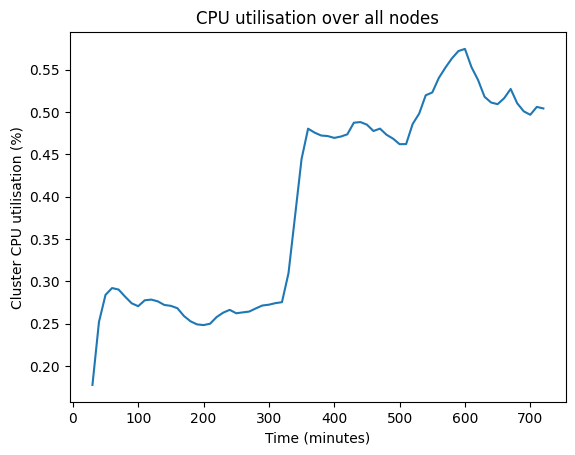

In [177]:
df_cpu = pd.DataFrame(raw_cpu_util, columns=['time', 'value'])
df_cpu['value'] = df_cpu['value'].astype(float)
df_cpu['time_mins'] = df_cpu['time'] / 60

df_cpu['value'].rolling(window=30).mean()[::10].plot(
  x='time_mins',
  xlabel='Time (minutes)',
  ylabel='Cluster CPU utilisation (%)',
  title='CPU utilisation over all nodes'
)

### Requested CPU and memory units of all pods

In [170]:
raw_cpu_limit_util = execute_promql_query(
  'sum(kube_pod_container_resource_limits{resource="cpu",namespace="default"}) / sum (machine_cpu_cores + 1e-6)',
  TIME_START,
  TIME_END
)

<Axes: title={'center': 'Requested vCPU units over time'}, xlabel='Time (minutes)', ylabel='Requested vCPU units (%)'>

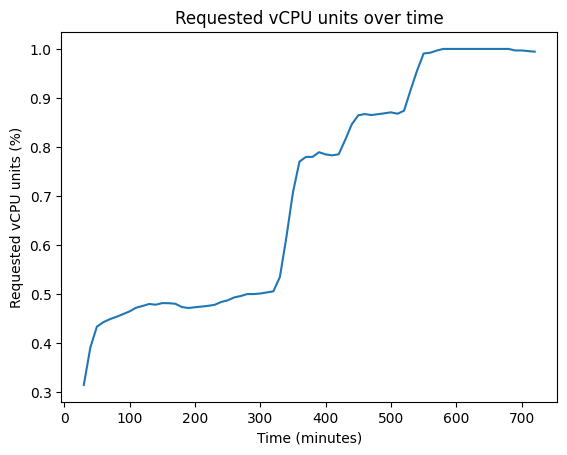

In [172]:
df_cpu_limit = pd.DataFrame(raw_cpu_limit_util, columns=['time', 'value'])
df_cpu_limit['value'] = df_cpu_limit['value'].astype(float).clip(upper=1)
df_cpu_limit['time_mins'] = df_cpu_limit['time'] / 60

df_cpu_limit['value'].rolling(window=30).mean()[::10].plot(
  x='time_mins',
  xlabel='Time (minutes)',
  ylabel='Requested vCPU units (%)',
  title='Requested vCPU units over time'
)

In [173]:
raw_memory_limit_util = execute_promql_query(
  'sum(kube_pod_container_resource_limits{resource="memory",namespace="default"}) / sum (machine_memory_bytes + 1e-6)',
  TIME_START,
  TIME_END
)

<Axes: title={'center': 'Requested memory units over time'}, xlabel='Time (minutes)', ylabel='Requested memory units (%)'>

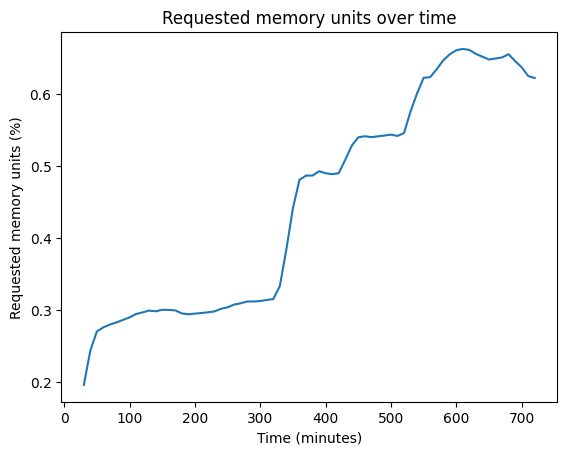

In [174]:
df_mem_limit = pd.DataFrame(raw_memory_limit_util, columns=['time', 'value'])
df_mem_limit['value'] = df_mem_limit['value'].astype(float).clip(upper=1)
df_mem_limit['time_mins'] = df_mem_limit['time'] / 60

df_mem_limit['value'].rolling(window=30).mean()[::10].plot(
  x='time_mins',
  xlabel='Time (minutes)',
  ylabel='Requested memory units (%)',
  title='Requested memory units over time'
)

### Memory utilisation

In [88]:
raw_mem_util = execute_promql_query(
  'sum (rate(container_memory_usage_bytes{namespace="default"}[45s])) / sum (machine_memory_bytes + 1e-6)',
  TIME_START,
  TIME_END
)

<Axes: title={'center': 'Memory utilisation over all nodes'}, xlabel='Time (minutes)', ylabel='Cluster memory utilisation'>

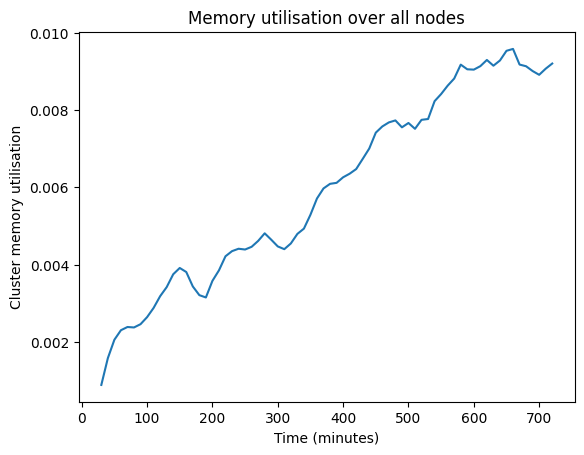

In [ ]:
df_mem = pd.DataFrame(raw_mem_util, columns=['time', 'value'])
df_mem['value'] = df_mem['value'].astype(float)
df_mem['time_mins'] = df_mem['time'] / 60

df_mem['value'].rolling(window=30).mean()[::10].plot(
  x='time_mins',
  xlabel='Time (minutes)',
  ylabel='Cluster memory utilisation',
  title='Memory utilisation over all nodes (%)'
)

### Total replicas/containers

In [93]:
raw_replica_count = execute_promql_query(
  'sum(kube_deployment_spec_replicas{namespace="default"})',
  TIME_START,
  TIME_END
)

<Axes: title={'center': 'Total amount of containers'}, xlabel='Time (minutes)', ylabel='Total containers'>

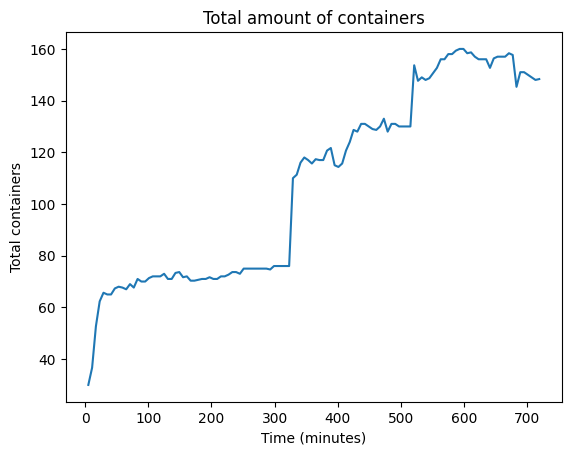

In [116]:
df_replica = pd.DataFrame(raw_replica_count, columns=['time', 'value'])
df_replica['value'] = df_replica['value'].astype(int)
df_replica['time_mins'] = (df_replica['time'] - df_replica['time'].iloc[0]) / 60

df_replica.rolling(window=3).mean()[::6].plot(
  x='time_mins',
  y='value',
  xlabel='Time (minutes)',
  ylabel='Total containers',
  title='Total amount of containers',
  legend=False
)

In [98]:
df_replica

,time,value,time_mins
0,1748919432,27.0,29148657.2
1,1748919492,27.0,29148658.2
2,1748919552,28.0,29148659.2
3,1748919612,29.0,29148660.2
4,1748919672,30.0,29148661.2
...,...,...,...
717,1748962452,147.0,29149374.2
718,1748962512,147.0,29149375.2
719,1748962572,149.0,29149376.2
720,1748962632,149.0,29149377.2


In [130]:
df = pd.read_csv('loadtest_stats_history.csv')
df = df[df['Name'] == 'Aggregated']
df

,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
0,1748919433,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000
1,1748919434,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000
2,1748919435,13,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000
5,1748919436,26,NaN,Aggregated,0.0,0.0,8.0,9.0,10.0,11.0,...,19.0,19.0,19.0,55,0,8.0,8.286835,1.796216,18.624696,18.600000
8,1748919437,39,NaN,Aggregated,0.0,0.0,8.0,9.0,10.0,10.0,...,38.0,38.0,38.0,205,0,8.0,8.008090,1.796216,37.726864,18.024390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129134,1748962733,1191,NaN,Aggregated,3360.4,0.0,270.0,340.0,410.0,460.0,...,1200.0,1600.0,2100.0,117841377,1638624,230.0,351.599392,0.821224,60005.372698,16.685518
129137,1748962734,1198,NaN,Aggregated,3335.1,0.0,260.0,340.0,400.0,440.0,...,1200.0,1700.0,2100.0,117849271,1638624,230.0,351.594247,0.821224,60005.372698,16.685477
129140,1748962735,1205,NaN,Aggregated,3409.1,0.0,260.0,330.0,400.0,440.0,...,1300.0,1700.0,2100.0,117852591,1638624,230.0,351.591803,0.821224,60005.372698,16.685469
129143,1748962736,1212,NaN,Aggregated,3409.1,0.0,260.0,330.0,390.0,430.0,...,1300.0,1700.0,2100.0,117852591,1638624,230.0,351.591803,0.821224,60005.372698,16.685469


In [160]:
df['time_minutes'] = ((df['Timestamp'] - df['Timestamp'].iloc[0])/60).astype(int)

In [ ]:
# total amount of requests
df['Total Request Count'].iloc[-1]

np.int64(117861686)

351.66722037079006


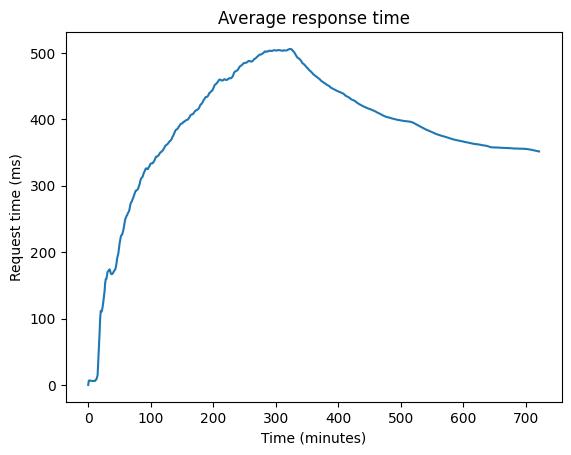

In [143]:
# average response time
tmp = pd.Series(
  df['Total Average Response Time'][::60].values,
  index=df['time_minutes'][::60]
)

tmp.plot(
  xlabel='Time (minutes)',
  ylabel='Request time (ms)',
  title='Average response time'
)

print(tmp.iloc[-1])

<Axes: title={'center': '99% tail latency'}, xlabel='Time (minutes)', ylabel='Request time (ms)'>

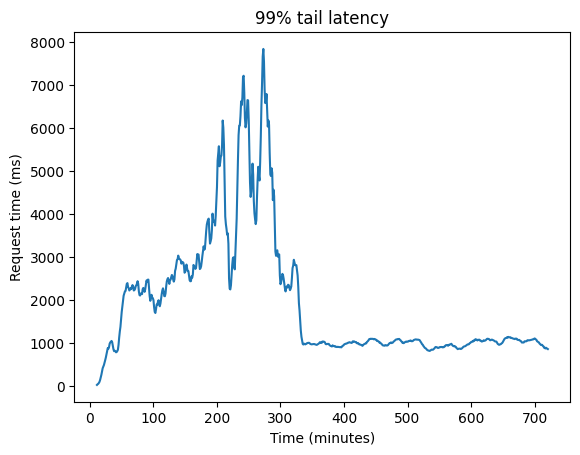

In [162]:
# average response time
tmp = pd.Series(
  df['99%'].rolling(window=600).mean()[::60].values,
  index=df['time_minutes'][::60]
)

tmp.plot(
  xlabel='Time (minutes)',
  ylabel='Request time (ms)',
  title='99% tail latency'
)

<Axes: title={'center': 'Total requests from all users'}, xlabel='Time (minutes)', ylabel='Request time (ms)'>

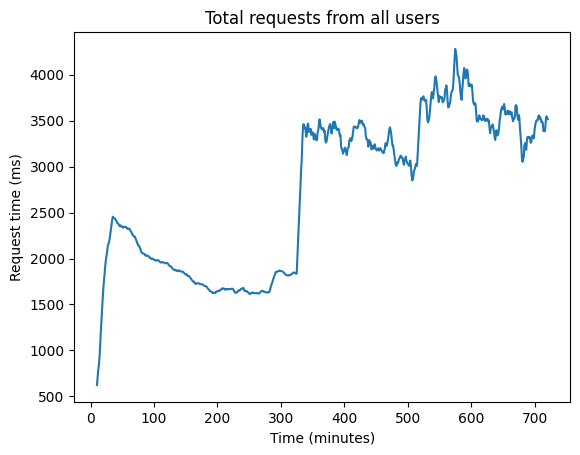

In [165]:
# rolling average of total requests
tmp = pd.Series(
  df['Requests/s'].rolling(window=600).mean()[::60].values,
  index=df['time_minutes'][::60]
)

tmp.plot(
  xlabel='Time (minutes)',
  ylabel='Request time (ms)',
  title='Total requests from all users'
)

<Axes: title={'center': 'Failed requests per second'}, xlabel='Time (minutes)', ylabel='Failures / second'>

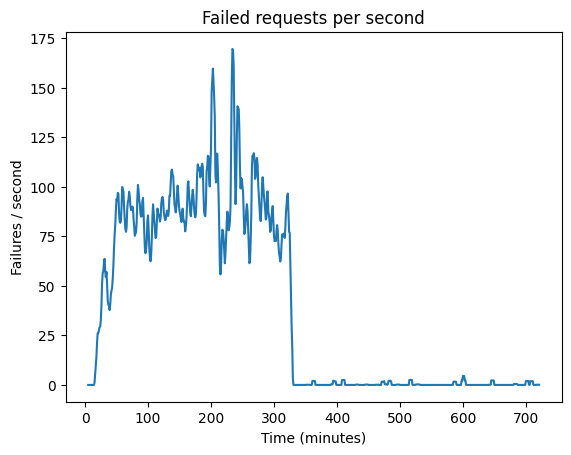

In [168]:
# failed requests
tmp = pd.Series(
  df['Failures/s'].rolling(window=300).mean()[::60].values,
  index=df['time_minutes'][::60]
)

tmp.plot(
  xlabel='Time (minutes)',
  ylabel='Failures / second',
  title='Failed requests per second'
)

In [117]:
# percent of failed requests
100 * df['Total Failure Count'].iloc[-1]/df['Total Request Count'].iloc[-1]

np.float64(1.390294043477369)